In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arch import arch_model
from arch.univariate import EWMAVariance
from arch.univariate import ZeroMean

import sys
sys.path.insert(0, '../')
from portfolio import *

In [2]:
rets = pd.read_excel('sp500_fundamentals.xlsx',sheet_name='total returns')
rets.set_index('Date',inplace=True)

spy = rets[['SPY']].copy().dropna()

# GARCH

- Estimation is sensitive to the scale of the data.
- For returns, this means typically better performance by scaling by 100, then deflating answer by 100

In [3]:
BURNIN = 60
WINDOW = 60
IGARCH_DECAY = .97
IGARCH_INIT = .15 / np.sqrt(12)
SCALE_GARCH = 100

vol = pd.DataFrame(index=spy.index)
vol['Unconditional'] = spy.std().values[0]
vol['Expanding Window'] = spy.expanding().std()
vol['Rolling Window'] = spy.rolling(WINDOW).std()

# IGARCH, (also known as EWMA), calculated via Pandas, with init condition included
vals_with_init_cond = pd.concat([pd.Series([IGARCH_INIT]), spy['SPY']])
# ewma variance
ewma_var = vals_with_init_cond.ewm(alpha=1-IGARCH_DECAY, adjust=False).var()
# transform to vol, remove initialized val
vol['IGARCH'] = ewma_var.iloc[1:]**(.5)

# GARCH(1,1), which is the default parameters of "arch_model"
garch_model = arch_model(spy * SCALE_GARCH).fit(disp='off')
vol['GARCH'] = garch_model.conditional_volatility / SCALE_GARCH

# annualize
vol *= np.sqrt(12)

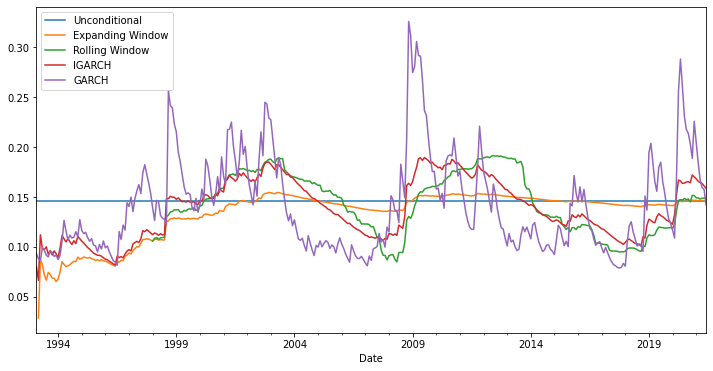

In [4]:
vol.plot(figsize=(12,6));

In [5]:
dates_of_interest = ['2008-Nov','2018-Jan']
tab = pd.DataFrame()
for dts in dates_of_interest:
    tab = pd.concat([tab,vol.loc[dts,:]],axis=0,join='outer')

tab

,Unconditional,Expanding Window,Rolling Window,IGARCH,GARCH
Date,,,,,
2008-11-30,0.145932,0.145778,0.130513,0.163752,0.325965
2018-01-31,0.145932,0.141575,0.095598,0.104422,0.080596
